# HydraNet Home Robot Project 🤖

In this workshop, you're going to learn how to train a Neural Network that does **real-time semantic segmentation and monocular depth prediction**.

![](https://d3i71xaburhd42.cloudfront.net/435d4b5c30f10753d277848a17baddebd98d3c31/2-Figure1-1.png)

The Model is [a Multi-Task Learning algorithm designed by Vladimir Nekrasov](https://arxiv.org/pdf/1809.04766.pdf). The entire work is based on the **DenseTorch Library**, that you can find and use [here](https://github.com/DrSleep/DenseTorch). <p>

* The **KITTI Dataset only has 200 examples of segmentation**. Therefore, the authors used a technique called Knowledge Distillation and finetuned using the Cityscape dataset.<p>

* 👉 In our case, we'll use another dataset called the [NYUDv2 Dataset](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html). **It contains 1449 annotated images for depth and segmentation**, which makes our life much simpler.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from lib.network.encoder import MobileNetv2
from lib.network.decoder import MTLWRefineNet
from lib.datasets import HydraNetDataset

# 1 — Dataset
Let's begin with importing our data, and visualizing it.

## Load and Visualize the Dataset

In [2]:
import glob

depth = sorted(glob.glob("nyud/depth/*.png"))
seg = sorted(glob.glob("nyud/masks/*.png"))
images = sorted(glob.glob("nyud/rgb/*.png"))

In [4]:
print(len(images))
print(len(depth))
print(len(seg))

1449
1449
1449


Since our dataset is a bit "special", we'll need a Color Map to read it.

In [5]:
CMAP = np.load('cmaps/cmap_nyud.npy')
print(len(CMAP))

256


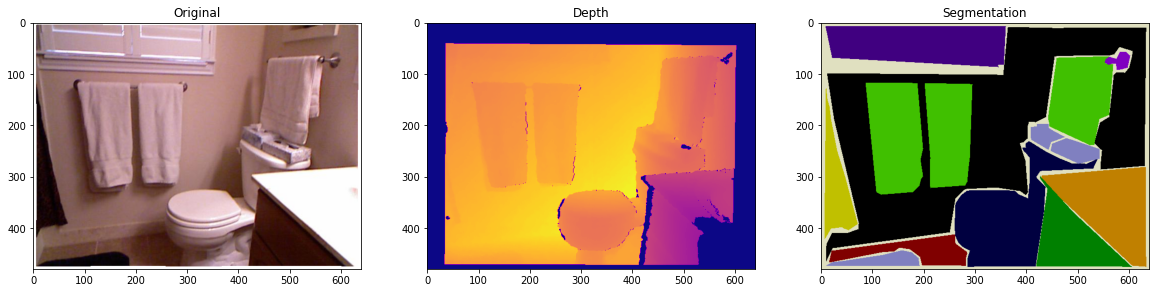

In [6]:
idx = np.random.randint(0,len(seg))

f, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(20,40))
ax0.imshow(np.array(Image.open(images[idx])))
ax0.set_title("Original")
ax1.imshow(np.array(Image.open(depth[idx])), cmap="plasma")
ax1.set_title("Depth")
ax2.imshow(CMAP[np.array(Image.open(seg[idx]))])
ax2.set_title("Segmentation")
plt.show()

In [7]:
print(np.unique(np.array(Image.open(seg[idx]))))
print(len(np.unique(np.array(Image.open(seg[idx])))))

[  0   1   2  11  12  26  27  32  37  39 255]
11


## Getting the DataLoader

When training a model, 2 elements are going to be very important (compared to the last workshop):

*   The Dataset
*   The Training Loop, Loss, etc

We already know how to design the model that does join depth and segmentation, so we only need to know how to train it!

In [8]:
data_file = "train_list_depth.txt"

with open(data_file, "rb") as f:
    datalist = f.readlines()
datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]

root_dir = "/nyud"
masks_names = ("segm", "depth")

print(datalist[0])

['rgb/000003.png', 'masks/000003.png', 'depth/000003.png']


In [9]:
import os
abs_paths = [os.path.join("nyud", rpath) for rpath in datalist[0]]
abs_paths

['nyud\\rgb/000003.png', 'nyud\\masks/000003.png', 'nyud\\depth/000003.png']

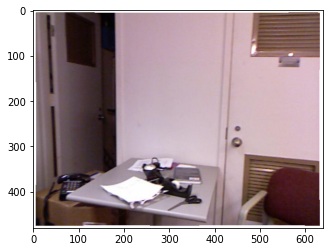

In [10]:
img_arr = np.array(Image.open(abs_paths[0]))

plt.imshow(img_arr)
plt.show()

segm


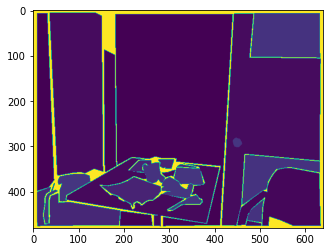

depth


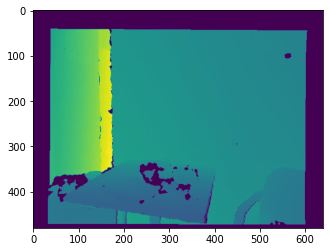

In [11]:
masks_names = ("segm", "depth")

for mask_name, mask_path in zip(masks_names, abs_paths[1:]):
    mask = np.array(Image.open(mask_path))
    print(mask_name)
    plt.imshow(mask)
    plt.show()

### Normalization — Will be common to all images


In [12]:
from utils import Normalise, RandomCrop, ToTensor, RandomMirror
import torchvision.transforms as transforms

In [13]:
img_scale = 1.0 / 255
depth_scale = 5000.0

img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

normalise_params = [img_scale, img_mean.reshape((1, 1, 3)), img_std.reshape((1, 1, 3)), depth_scale,]

transform_common = [Normalise(*normalise_params), ToTensor()]

### Transforms

In [14]:
crop_size = 400
transform_train = transforms.Compose([RandomMirror(), RandomCrop(crop_size)] + transform_common)
transform_val = transforms.Compose(transform_common)

### DataLoader

In [15]:
train_batch_size = 4
val_batch_size = 4
train_file = "train_list_depth.txt"
val_file = "val_list_depth.txt"

In [17]:
from torch.utils.data import DataLoader

#TRAIN DATALOADER
trainloader = DataLoader(
    HydraNetDataset(train_file, transform=transform_train,),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True,
)

# VALIDATION DATALOADER
valloader = DataLoader(
    HydraNetDataset(val_file, transform=transform_val,),
    batch_size=val_batch_size, 
    shuffle=False, num_workers=4, 
    pin_memory=True,
    drop_last=False,
)

# 2 — Creating the HydraNet
We now have 2 DataLoaders: one for training, and one for validation/test. <p>

In the next step, we're going to define our model, following the paper [Real-Time Joint Semantic Segmentation and Depth Estimation Using Asymmetric Annotations](https://arxiv.org/pdf/1809.04766.pdf) —— If you haven't read it yet, now is the time.
<p>

> ![](https://d3i71xaburhd42.cloudfront.net/435d4b5c30f10753d277848a17baddebd98d3c31/2-Figure1-1.png)

Our model takes an input RGB image, make it go through an encoder, a lightweight refinenet decoder, and then has 2 heads, one for each task.<p>
Things to note:
* The only **convolutions** we'll need will be 3x3 and 1x1
* We also need a **MaxPooling 5x5**
* **CRP-Blocks** are implemented as Skip-Connection Operations
* **Each Head is made of a 1x1 convolution followed by a 3x3 convolution**, only the data and the loss change there


## Building the Encoder — A MobileNetv2
![](https://iq.opengenus.org/content/images/2020/11/conv_mobilenet_v2.jpg)

In [19]:
encoder = MobileNetv2()
encoder.load_state_dict(torch.load("models/mobilenetv2-e6e8dd43.pth"))

<All keys matched successfully>

In [20]:
print(encoder)

MobileNetv2(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (layer2): Sequential(
    (0): InvertedResidualBlock(
      (output): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (2): Sequential(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, af

## Building the Decoder - A Multi-Task Lighweight RefineNet
Paper: https://arxiv.org/pdf/1810.03272.pdf
![](https://drsleep.github.io/images/rf_arch.png)

In [21]:
def make_list(x):
    """Returns the given input as a list."""
    if isinstance(x, list):
        return x
    elif isinstance(x, tuple):
        return list(x)
    else:
        return [x]

In [23]:
num_classes = (40, 1)
decoder = MTLWRefineNet(encoder._out_c, num_classes)
print(decoder)

MTLWRefineNet(
  (stem_convs): ModuleList(
    (0): Conv2d(320, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): Conv2d(160, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Conv2d(96, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (4): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): Conv2d(24, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (crp_blocks): ModuleList(
    (0): Sequential(
      (0): CRPBlock(
        (1_outvar_dimred): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2_outvar_dimred): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3_outvar_dimred): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4_outvar_dimred): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (maxpool): MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mod

# 3 — Train the Model

Now that we've define our encoder and decoder. We are ready to train our model on the NYUDv2 Dataset.

Here's what we'll need:

*   Functions like **train() and valid()**
*   **An Optimizer and a Loss Function**
*   **Hyperparameters** such as Weight Decay, Momentum, Learning Rate, Epochs, ...

Doesn't sound so bad, does it?

## Loss Function

Let's begin with the Loss and Optimization we'll need.

* The **Segmentation Loss** is the **Cross Entropy Loss**, working as a per-pixel classification function with 15 or so classes.

* The **Depth Loss** will be the **Inverse Huber Loss**.

In [24]:
from utils import InvHuberLoss

ignore_index = 255
ignore_depth = 0

crit_segm = nn.CrossEntropyLoss(ignore_index=ignore_index).cuda()
crit_depth = InvHuberLoss(ignore_index=ignore_depth).cuda()

## Optimizer
For the optimizer, we'll use the **Stochastic Gradient Descent**. We'll also add techniques such as weight decay or momentum.

In [25]:
lr_encoder = 1e-2
lr_decoder = 1e-3
momentum_encoder = 0.9
momentum_decoder = 0.9
weight_decay_encoder = 1e-5
weight_decay_decoder = 1e-5

In [26]:
optims = [torch.optim.SGD(encoder.parameters(), lr=lr_encoder, momentum=momentum_encoder, weight_decay=weight_decay_encoder),
         torch.optim.SGD(decoder.parameters(), lr=lr_decoder, momentum=momentum_decoder, weight_decay=weight_decay_decoder)]

## Model Definition & State Loading

In [27]:
n_epochs = 1000

In [29]:
from lib.utils.model_helpers import Saver, load_state_dict
import operator 
import json
import logging

init_vals = (0.0, 10000.0)
comp_fns = [operator.gt, operator.lt]
ckpt_dir = "./"
ckpt_path = "./checkpoint.pth.tar"

saver = Saver(
    args=locals(),
    ckpt_dir=ckpt_dir,
    best_val=init_vals,
    condition=comp_fns,
    save_several_mode=all,
)

In [31]:
hydranet = nn.DataParallel(nn.Sequential(encoder, decoder))#.cuda()) # Use .cpu() if you prefer a slow death

print("Model has {} parameters".format(sum([p.numel() for p in hydranet.parameters()])))

start_epoch, _, state_dict = saver.maybe_load(ckpt_path=ckpt_path, keys_to_load=["epoch", "best_val", "state_dict"],)
load_state_dict(hydranet, state_dict)

if start_epoch is None:
    start_epoch = 0

Model has 3070057 parameters


In [32]:
print(start_epoch)

0


## Learning Rate Scheduler

In [ ]:
opt_scheds = []
for opt in optims:
    opt_scheds.append(torch.optim.lr_scheduler.MultiStepLR(opt, np.arange(start_epoch + 1, n_epochs, 100), gamma=0.1))

## Training and Validation Loops

Now, all we need to do is go through the Train and Validation DataLoaders, and train our model.

In [ ]:
from utils import AverageMeter
from tqdm import tqdm

In [ ]:
def train(model, opts, crits, dataloader, loss_coeffs=(1.0,), grad_norm=0.0):
    model.train()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_meter = AverageMeter()
    pbar = tqdm(dataloader)

    for sample in pbar:
        loss = 0.0
        input = sample["image"].float().to(device)
        targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]
        
        #FORWARD
        outputs = model(input)

        for out, target, crit, loss_coeff in zip(outputs, targets, crits, loss_coeffs):
            #TODO: Increment the Loss
            loss += loss_coeff * crit(
                F.interpolate(
                    out, size=target.size()[1:], mode="bilinear", align_corners=False
                ).squeeze(dim=1),
                target.squeeze(dim=1),)

        # BACKWARD
        for opt in opts:
          opt.zero_grad()
        loss.backward()

        if grad_norm > 0.0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
        #TODO: Run one step
        for opt in opts:
            opt.step()

        loss_meter.update(loss.item())
        pbar.set_description(
            "Loss {:.3f} | Avg. Loss {:.3f}".format(loss.item(), loss_meter.avg)
        )

In [ ]:
def validate(model, metrics, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    for metric in metrics:
        metric.reset()

    pbar = tqdm(dataloader)

    def get_val(metrics):
        results = [(m.name, m.val()) for m in metrics]
        names, vals = list(zip(*results))
        out = ["{} : {:4f}".format(name, val) for name, val in results]
        return vals, " | ".join(out)

    with torch.no_grad():
        for sample in pbar:
            # Get the Data
            input = sample["image"].float().to(device)
            targets = [sample[k].to(device) for k in dataloader.dataset.masks_names]

            #input, targets = get_input_and_targets(sample=sample, dataloader=dataloader, device=device)
            targets = [target.squeeze(dim=1).cpu().numpy() for target in targets]

            # Forward
            outputs = model(input)
            #outputs = make_list(outputs)

            # Backward
            for out, target, metric in zip(outputs, targets, metrics):
                metric.update(
                    F.interpolate(out, size=target.shape[1:], mode="bilinear", align_corners=False)
                    .squeeze(dim=1)
                    .cpu()
                    .numpy(),
                    target,
                )
            pbar.set_description(get_val(metrics)[1])
    vals, _ = get_val(metrics)
    print("----" * 5)
    return vals

## Main Loop

In [ ]:
from utils import MeanIoU, RMSE

In [ ]:
crop_size = 400
batch_size = 4
val_batch_size = 4
val_every = 5
loss_coeffs = (0.5, 0.5)

for i in range(start_epoch, n_epochs):
    for sched in opt_scheds:
        sched.step(i)
    
    print("Epoch {:d}".format(i))
    train(hydranet, optims, [crit_segm, crit_depth], trainloader, loss_coeffs)
    
    if i % val_every == 0:
        metrics = [MeanIoU(num_classes[0]),RMSE(ignore_val=ignore_depth),]

        with torch.no_grad():
            vals = validate(hydranet, metrics, valloader)
        saver.maybe_save(new_val=vals, dict_to_save={"state_dict": hydranet.state_dict(), "epoch": i})

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

Epoch 0


Loss 1.437 | Avg. Loss 2.095: 100%|██████████| 198/198 [00:39<00:00,  5.00it/s]
meaniou : 0.017700 | rmse : 1.094223: 100%|██████████| 164/164 [02:43<00:00,  1.01it/s]


--------------------
Epoch 1


Loss 1.693 | Avg. Loss 1.740: 100%|██████████| 198/198 [00:33<00:00,  5.83it/s]


Epoch 2


Loss 1.407 | Avg. Loss 1.731: 100%|██████████| 198/198 [00:35<00:00,  5.66it/s]


Epoch 3


Loss 1.316 | Avg. Loss 1.626: 100%|██████████| 198/198 [00:34<00:00,  5.79it/s]


Epoch 4


Loss 1.559 | Avg. Loss 1.618: 100%|██████████| 198/198 [00:34<00:00,  5.71it/s]


Epoch 5


Loss 1.585 | Avg. Loss 1.647: 100%|██████████| 198/198 [00:34<00:00,  5.66it/s]
meaniou : 0.031359 | rmse : 1.019309: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 6


Loss 1.434 | Avg. Loss 1.607: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 7


Loss 1.473 | Avg. Loss 1.649: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 8


Loss 1.364 | Avg. Loss 1.590: 100%|██████████| 198/198 [00:35<00:00,  5.51it/s]


Epoch 9


Loss 1.364 | Avg. Loss 1.551: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]


Epoch 10


Loss 1.491 | Avg. Loss 1.549: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]
meaniou : 0.042724 | rmse : 0.932338: 100%|██████████| 164/164 [02:44<00:00,  1.01s/it]


--------------------
Epoch 11


Loss 1.516 | Avg. Loss 1.493: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]


Epoch 12


Loss 1.772 | Avg. Loss 1.534: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 13


Loss 1.601 | Avg. Loss 1.477: 100%|██████████| 198/198 [00:34<00:00,  5.66it/s]


Epoch 14


Loss 1.277 | Avg. Loss 1.483: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 15


Loss 1.780 | Avg. Loss 1.490: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]
meaniou : 0.051740 | rmse : 0.863311: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 16


Loss 1.300 | Avg. Loss 1.473: 100%|██████████| 198/198 [00:33<00:00,  5.84it/s]


Epoch 17


Loss 1.305 | Avg. Loss 1.433: 100%|██████████| 198/198 [00:34<00:00,  5.68it/s]


Epoch 18


Loss 1.139 | Avg. Loss 1.378: 100%|██████████| 198/198 [00:34<00:00,  5.71it/s]


Epoch 19


Loss 1.469 | Avg. Loss 1.392: 100%|██████████| 198/198 [00:34<00:00,  5.75it/s]


Epoch 20


Loss 1.241 | Avg. Loss 1.435: 100%|██████████| 198/198 [00:34<00:00,  5.68it/s]
meaniou : 0.062288 | rmse : 0.832481: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 21


Loss 1.341 | Avg. Loss 1.431: 100%|██████████| 198/198 [00:35<00:00,  5.53it/s]


Epoch 22


Loss 1.445 | Avg. Loss 1.358: 100%|██████████| 198/198 [00:34<00:00,  5.75it/s]


Epoch 23


Loss 1.182 | Avg. Loss 1.354: 100%|██████████| 198/198 [00:34<00:00,  5.74it/s]


Epoch 24


Loss 1.209 | Avg. Loss 1.352: 100%|██████████| 198/198 [00:34<00:00,  5.73it/s]


Epoch 25


Loss 1.258 | Avg. Loss 1.355: 100%|██████████| 198/198 [00:35<00:00,  5.66it/s]
meaniou : 0.062223 | rmse : 0.821398: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 26


Loss 1.447 | Avg. Loss 1.298: 100%|██████████| 198/198 [00:34<00:00,  5.71it/s]


Epoch 27


Loss 1.647 | Avg. Loss 1.316: 100%|██████████| 198/198 [00:34<00:00,  5.66it/s]


Epoch 28


Loss 1.092 | Avg. Loss 1.280: 100%|██████████| 198/198 [00:35<00:00,  5.53it/s]


Epoch 29


Loss 1.292 | Avg. Loss 1.296: 100%|██████████| 198/198 [00:34<00:00,  5.69it/s]


Epoch 30


Loss 1.035 | Avg. Loss 1.252: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]
meaniou : 0.069148 | rmse : 0.857541: 100%|██████████| 164/164 [02:44<00:00,  1.01s/it]


--------------------
Epoch 31


Loss 1.575 | Avg. Loss 1.293: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 32


Loss 1.142 | Avg. Loss 1.268: 100%|██████████| 198/198 [00:34<00:00,  5.73it/s]


Epoch 33


Loss 1.420 | Avg. Loss 1.253: 100%|██████████| 198/198 [00:34<00:00,  5.73it/s]


Epoch 34


Loss 1.289 | Avg. Loss 1.311: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 35


Loss 1.088 | Avg. Loss 1.231: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]
meaniou : 0.075933 | rmse : 0.811883: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 36


Loss 1.148 | Avg. Loss 1.251: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 37


Loss 1.397 | Avg. Loss 1.209: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]


Epoch 38


Loss 1.210 | Avg. Loss 1.248: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 39


Loss 1.229 | Avg. Loss 1.202: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 40


Loss 1.129 | Avg. Loss 1.204: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]
meaniou : 0.084264 | rmse : 0.797544: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 41


Loss 1.177 | Avg. Loss 1.245: 100%|██████████| 198/198 [00:34<00:00,  5.69it/s]


Epoch 42


Loss 1.285 | Avg. Loss 1.198: 100%|██████████| 198/198 [00:35<00:00,  5.53it/s]


Epoch 43


Loss 0.932 | Avg. Loss 1.191: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]


Epoch 44


Loss 1.147 | Avg. Loss 1.181: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 45


Loss 0.897 | Avg. Loss 1.163: 100%|██████████| 198/198 [00:34<00:00,  5.70it/s]
meaniou : 0.089062 | rmse : 0.779555: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 46


Loss 1.106 | Avg. Loss 1.157: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 47


Loss 1.294 | Avg. Loss 1.222: 100%|██████████| 198/198 [00:34<00:00,  5.71it/s]


Epoch 48


Loss 1.378 | Avg. Loss 1.153: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]


Epoch 49


Loss 1.063 | Avg. Loss 1.169: 100%|██████████| 198/198 [00:34<00:00,  5.70it/s]


Epoch 50


Loss 1.027 | Avg. Loss 1.123: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]
meaniou : 0.096710 | rmse : 0.773341: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 51


Loss 0.945 | Avg. Loss 1.108: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 52


Loss 0.978 | Avg. Loss 1.110: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]


Epoch 53


Loss 0.938 | Avg. Loss 1.117: 100%|██████████| 198/198 [00:34<00:00,  5.73it/s]


Epoch 54


Loss 1.258 | Avg. Loss 1.106: 100%|██████████| 198/198 [00:34<00:00,  5.73it/s]


Epoch 55


Loss 1.192 | Avg. Loss 1.089: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]
meaniou : 0.104761 | rmse : 0.756236: 100%|██████████| 164/164 [02:46<00:00,  1.02s/it]


--------------------
Epoch 56


Loss 1.193 | Avg. Loss 1.080: 100%|██████████| 198/198 [00:36<00:00,  5.47it/s]


Epoch 57


Loss 1.002 | Avg. Loss 1.060: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]


Epoch 58


Loss 1.131 | Avg. Loss 1.085: 100%|██████████| 198/198 [00:35<00:00,  5.56it/s]


Epoch 59


Loss 1.079 | Avg. Loss 1.087: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 60


Loss 1.419 | Avg. Loss 1.116: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]
meaniou : 0.111035 | rmse : 0.752845: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 61


Loss 1.037 | Avg. Loss 1.048: 100%|██████████| 198/198 [00:35<00:00,  5.66it/s]


Epoch 62


Loss 0.927 | Avg. Loss 1.029: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 63


Loss 1.476 | Avg. Loss 1.063: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 64


Loss 1.275 | Avg. Loss 1.055: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]


Epoch 65


Loss 0.700 | Avg. Loss 1.033: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]
meaniou : 0.119609 | rmse : 0.751944: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 66


Loss 1.097 | Avg. Loss 1.042: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 67


Loss 0.928 | Avg. Loss 1.027: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 68


Loss 1.063 | Avg. Loss 1.037: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 69


Loss 0.975 | Avg. Loss 1.028: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 70


Loss 1.049 | Avg. Loss 1.022: 100%|██████████| 198/198 [00:35<00:00,  5.56it/s]
meaniou : 0.124400 | rmse : 0.747504: 100%|██████████| 164/164 [02:44<00:00,  1.01s/it]


--------------------
Epoch 71


Loss 0.982 | Avg. Loss 0.997: 100%|██████████| 198/198 [00:35<00:00,  5.51it/s]


Epoch 72


Loss 0.887 | Avg. Loss 1.006: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 73


Loss 0.951 | Avg. Loss 0.988: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 74


Loss 1.242 | Avg. Loss 0.983: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]


Epoch 75


Loss 1.126 | Avg. Loss 0.984: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]
meaniou : 0.129493 | rmse : 0.735302: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 76


Loss 0.971 | Avg. Loss 0.987: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 77


Loss 0.938 | Avg. Loss 0.978: 100%|██████████| 198/198 [00:35<00:00,  5.51it/s]


Epoch 78


Loss 0.951 | Avg. Loss 0.963: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 79


Loss 0.881 | Avg. Loss 0.970: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 80


Loss 0.729 | Avg. Loss 0.931: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]
meaniou : 0.133212 | rmse : 0.753036: 100%|██████████| 164/164 [02:46<00:00,  1.01s/it]


--------------------
Epoch 81


Loss 1.000 | Avg. Loss 0.962: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 82


Loss 0.751 | Avg. Loss 0.980: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]


Epoch 83


Loss 0.866 | Avg. Loss 0.945: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]


Epoch 84


Loss 1.116 | Avg. Loss 0.950: 100%|██████████| 198/198 [00:35<00:00,  5.53it/s]


Epoch 85


Loss 1.196 | Avg. Loss 0.945: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]
meaniou : 0.141834 | rmse : 0.732788: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 86


Loss 0.895 | Avg. Loss 0.927: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 87


Loss 0.869 | Avg. Loss 0.952: 100%|██████████| 198/198 [00:34<00:00,  5.70it/s]


Epoch 88


Loss 1.052 | Avg. Loss 0.920: 100%|██████████| 198/198 [00:34<00:00,  5.68it/s]


Epoch 89


Loss 0.862 | Avg. Loss 0.910: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]


Epoch 90


Loss 0.830 | Avg. Loss 0.908: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]
meaniou : 0.148325 | rmse : 0.721982: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 91


Loss 1.023 | Avg. Loss 0.900: 100%|██████████| 198/198 [00:34<00:00,  5.71it/s]


Epoch 92


Loss 1.004 | Avg. Loss 0.980: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 93


Loss 0.942 | Avg. Loss 0.908: 100%|██████████| 198/198 [00:34<00:00,  5.76it/s]


Epoch 94


Loss 0.915 | Avg. Loss 0.896: 100%|██████████| 198/198 [00:34<00:00,  5.68it/s]


Epoch 95


Loss 1.133 | Avg. Loss 0.923: 100%|██████████| 198/198 [00:34<00:00,  5.75it/s]
meaniou : 0.152385 | rmse : 0.739898: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 96


Loss 1.018 | Avg. Loss 0.875: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 97


Loss 1.155 | Avg. Loss 0.879: 100%|██████████| 198/198 [00:34<00:00,  5.68it/s]


Epoch 98


Loss 0.895 | Avg. Loss 0.851: 100%|██████████| 198/198 [00:36<00:00,  5.45it/s]


Epoch 99


Loss 0.730 | Avg. Loss 0.881: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 100


Loss 1.009 | Avg. Loss 0.848: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]
meaniou : 0.156435 | rmse : 0.718466: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 101


Loss 0.646 | Avg. Loss 0.849: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 102


Loss 1.006 | Avg. Loss 0.863: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 103


Loss 0.709 | Avg. Loss 0.872: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 104


Loss 1.189 | Avg. Loss 0.858: 100%|██████████| 198/198 [00:34<00:00,  5.66it/s]


Epoch 105


Loss 0.735 | Avg. Loss 0.865: 100%|██████████| 198/198 [00:35<00:00,  5.52it/s]
meaniou : 0.156747 | rmse : 0.708705: 100%|██████████| 164/164 [02:43<00:00,  1.00it/s]


--------------------
Epoch 106


Loss 0.678 | Avg. Loss 0.839: 100%|██████████| 198/198 [00:36<00:00,  5.49it/s]


Epoch 107


Loss 0.884 | Avg. Loss 0.818: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 108


Loss 1.097 | Avg. Loss 0.876: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 109


Loss 0.553 | Avg. Loss 0.824: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 110


Loss 0.628 | Avg. Loss 0.815: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]
meaniou : 0.158110 | rmse : 0.706235: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 111


Loss 0.923 | Avg. Loss 0.870: 100%|██████████| 198/198 [00:33<00:00,  5.90it/s]


Epoch 112


Loss 0.754 | Avg. Loss 0.831: 100%|██████████| 198/198 [00:33<00:00,  5.86it/s]


Epoch 113


Loss 0.676 | Avg. Loss 0.842: 100%|██████████| 198/198 [00:34<00:00,  5.79it/s]


Epoch 114


Loss 0.725 | Avg. Loss 0.839: 100%|██████████| 198/198 [00:33<00:00,  5.86it/s]


Epoch 115


Loss 0.728 | Avg. Loss 0.841: 100%|██████████| 198/198 [00:33<00:00,  5.90it/s]
meaniou : 0.155929 | rmse : 0.707997: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 116


Loss 0.755 | Avg. Loss 0.811: 100%|██████████| 198/198 [00:33<00:00,  5.89it/s]


Epoch 117


Loss 0.944 | Avg. Loss 0.847: 100%|██████████| 198/198 [00:33<00:00,  5.88it/s]


Epoch 118


Loss 0.854 | Avg. Loss 0.848: 100%|██████████| 198/198 [00:33<00:00,  5.86it/s]


Epoch 119


Loss 0.792 | Avg. Loss 0.838: 100%|██████████| 198/198 [00:34<00:00,  5.72it/s]


Epoch 120


Loss 0.723 | Avg. Loss 0.830: 100%|██████████| 198/198 [00:33<00:00,  5.86it/s]
meaniou : 0.159360 | rmse : 0.708592: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 121


Loss 0.716 | Avg. Loss 0.826: 100%|██████████| 198/198 [00:33<00:00,  5.88it/s]


Epoch 122


Loss 0.738 | Avg. Loss 0.810: 100%|██████████| 198/198 [00:33<00:00,  5.88it/s]


Epoch 123


Loss 1.112 | Avg. Loss 0.816: 100%|██████████| 198/198 [00:33<00:00,  5.86it/s]


Epoch 124


Loss 0.942 | Avg. Loss 0.834: 100%|██████████| 198/198 [00:34<00:00,  5.80it/s]


Epoch 125


Loss 0.894 | Avg. Loss 0.809: 100%|██████████| 198/198 [00:33<00:00,  5.93it/s]
meaniou : 0.158665 | rmse : 0.703020: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 126


Loss 1.043 | Avg. Loss 0.826: 100%|██████████| 198/198 [00:33<00:00,  5.84it/s]


Epoch 127


Loss 0.786 | Avg. Loss 0.823: 100%|██████████| 198/198 [00:34<00:00,  5.79it/s]


Epoch 128


Loss 0.886 | Avg. Loss 0.792: 100%|██████████| 198/198 [00:33<00:00,  5.88it/s]


Epoch 129


Loss 0.864 | Avg. Loss 0.828: 100%|██████████| 198/198 [00:33<00:00,  5.85it/s]


Epoch 130


Loss 0.813 | Avg. Loss 0.852: 100%|██████████| 198/198 [00:33<00:00,  5.88it/s]
meaniou : 0.160961 | rmse : 0.705003: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 131


Loss 0.668 | Avg. Loss 0.844: 100%|██████████| 198/198 [00:34<00:00,  5.77it/s]


Epoch 132


Loss 0.853 | Avg. Loss 0.819: 100%|██████████| 198/198 [00:33<00:00,  5.98it/s]


Epoch 133


Loss 0.768 | Avg. Loss 0.809: 100%|██████████| 198/198 [00:33<00:00,  5.91it/s]


Epoch 134


Loss 0.743 | Avg. Loss 0.804: 100%|██████████| 198/198 [00:34<00:00,  5.74it/s]


Epoch 135


Loss 0.819 | Avg. Loss 0.802: 100%|██████████| 198/198 [00:33<00:00,  5.91it/s]
meaniou : 0.161116 | rmse : 0.704737: 100%|██████████| 164/164 [02:42<00:00,  1.01it/s]


--------------------
Epoch 136


Loss 1.045 | Avg. Loss 0.800: 100%|██████████| 198/198 [00:34<00:00,  5.70it/s]


Epoch 137


Loss 0.811 | Avg. Loss 0.817: 100%|██████████| 198/198 [00:33<00:00,  5.88it/s]


Epoch 138


Loss 0.790 | Avg. Loss 0.798: 100%|██████████| 198/198 [00:33<00:00,  5.84it/s]


Epoch 139


Loss 0.728 | Avg. Loss 0.829: 100%|██████████| 198/198 [00:34<00:00,  5.81it/s]


Epoch 140


Loss 0.762 | Avg. Loss 0.829: 100%|██████████| 198/198 [00:34<00:00,  5.81it/s]
meaniou : 0.163433 | rmse : 0.706211: 100%|██████████| 164/164 [02:44<00:00,  1.00s/it]


--------------------
Epoch 141


Loss 0.645 | Avg. Loss 0.814: 100%|██████████| 198/198 [00:33<00:00,  5.85it/s]


Epoch 142


Loss 0.657 | Avg. Loss 0.803: 100%|██████████| 198/198 [00:34<00:00,  5.76it/s]


Epoch 143


Loss 0.784 | Avg. Loss 0.801: 100%|██████████| 198/198 [00:34<00:00,  5.81it/s]


Epoch 144


Loss 0.755 | Avg. Loss 0.857: 100%|██████████| 198/198 [00:33<00:00,  5.87it/s]


Epoch 145


Loss 0.825 | Avg. Loss 0.799: 100%|██████████| 198/198 [00:34<00:00,  5.80it/s]
meaniou : 0.163616 | rmse : 0.705063: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 146


Loss 0.721 | Avg. Loss 0.800: 100%|██████████| 198/198 [00:33<00:00,  5.91it/s]


Epoch 147


Loss 0.641 | Avg. Loss 0.792: 100%|██████████| 198/198 [00:34<00:00,  5.78it/s]


Epoch 148


Loss 0.679 | Avg. Loss 0.789: 100%|██████████| 198/198 [00:34<00:00,  5.80it/s]


Epoch 149


Loss 0.779 | Avg. Loss 0.834: 100%|██████████| 198/198 [00:34<00:00,  5.80it/s]


Epoch 150


Loss 0.706 | Avg. Loss 0.813: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]
meaniou : 0.167298 | rmse : 0.701628: 100%|██████████| 164/164 [02:45<00:00,  1.01s/it]


--------------------
Epoch 151


Loss 0.993 | Avg. Loss 0.813: 100%|██████████| 198/198 [00:34<00:00,  5.81it/s]


Epoch 152


Loss 0.903 | Avg. Loss 0.812: 100%|██████████| 198/198 [00:33<00:00,  5.84it/s]


Epoch 153


Loss 0.834 | Avg. Loss 0.808: 100%|██████████| 198/198 [00:34<00:00,  5.76it/s]


Epoch 154


Loss 0.783 | Avg. Loss 0.813: 100%|██████████| 198/198 [00:34<00:00,  5.81it/s]


Epoch 155


Loss 0.804 | Avg. Loss 0.787: 100%|██████████| 198/198 [00:33<00:00,  5.91it/s]
meaniou : 0.163699 | rmse : 0.707308: 100%|██████████| 164/164 [02:46<00:00,  1.01s/it]


--------------------
Epoch 156


Loss 0.789 | Avg. Loss 0.831: 100%|██████████| 198/198 [00:34<00:00,  5.81it/s]


Epoch 157


Loss 0.571 | Avg. Loss 0.850: 100%|██████████| 198/198 [00:34<00:00,  5.73it/s]


Epoch 158


Loss 0.815 | Avg. Loss 0.807: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]


Epoch 159


Loss 0.638 | Avg. Loss 0.795: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 160


Loss 0.797 | Avg. Loss 0.811: 100%|██████████| 198/198 [00:34<00:00,  5.76it/s]
meaniou : 0.165756 | rmse : 0.705555: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 161


Loss 0.714 | Avg. Loss 0.821: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 162


Loss 1.051 | Avg. Loss 0.799: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]


Epoch 163


Loss 1.169 | Avg. Loss 0.825: 100%|██████████| 198/198 [00:34<00:00,  5.70it/s]


Epoch 164


Loss 0.696 | Avg. Loss 0.839: 100%|██████████| 198/198 [00:35<00:00,  5.52it/s]


Epoch 165


Loss 0.961 | Avg. Loss 0.790: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]
meaniou : 0.166643 | rmse : 0.708050: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 166


Loss 0.641 | Avg. Loss 0.826: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 167


Loss 0.803 | Avg. Loss 0.843: 100%|██████████| 198/198 [00:34<00:00,  5.72it/s]


Epoch 168


Loss 0.728 | Avg. Loss 0.779: 100%|██████████| 198/198 [00:34<00:00,  5.74it/s]


Epoch 169


Loss 0.729 | Avg. Loss 0.788: 100%|██████████| 198/198 [00:34<00:00,  5.73it/s]


Epoch 170


Loss 0.980 | Avg. Loss 0.857: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]
meaniou : 0.169703 | rmse : 0.703467: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 171


Loss 0.627 | Avg. Loss 0.794: 100%|██████████| 198/198 [00:34<00:00,  5.68it/s]


Epoch 172


Loss 0.675 | Avg. Loss 0.795: 100%|██████████| 198/198 [00:35<00:00,  5.50it/s]


Epoch 173


Loss 0.799 | Avg. Loss 0.824: 100%|██████████| 198/198 [00:34<00:00,  5.66it/s]


Epoch 174


Loss 0.575 | Avg. Loss 0.789: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]


Epoch 175


Loss 1.008 | Avg. Loss 0.824: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]
meaniou : 0.168117 | rmse : 0.701957: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 176


Loss 1.006 | Avg. Loss 0.756: 100%|██████████| 198/198 [00:34<00:00,  5.69it/s]


Epoch 177


Loss 0.926 | Avg. Loss 0.812: 100%|██████████| 198/198 [00:34<00:00,  5.69it/s]


Epoch 178


Loss 0.822 | Avg. Loss 0.803: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 179


Loss 0.814 | Avg. Loss 0.827: 100%|██████████| 198/198 [00:34<00:00,  5.72it/s]


Epoch 180


Loss 0.843 | Avg. Loss 0.776: 100%|██████████| 198/198 [00:34<00:00,  5.74it/s]
meaniou : 0.168521 | rmse : 0.701142: 100%|██████████| 164/164 [02:46<00:00,  1.02s/it]


--------------------
Epoch 181


Loss 0.660 | Avg. Loss 0.811: 100%|██████████| 198/198 [00:34<00:00,  5.74it/s]


Epoch 182


Loss 0.706 | Avg. Loss 0.810: 100%|██████████| 198/198 [00:34<00:00,  5.78it/s]


Epoch 183


Loss 0.781 | Avg. Loss 0.807: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 184


Loss 0.808 | Avg. Loss 0.815: 100%|██████████| 198/198 [00:34<00:00,  5.74it/s]


Epoch 185


Loss 0.999 | Avg. Loss 0.781: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]
meaniou : 0.166654 | rmse : 0.703251: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 186


Loss 0.545 | Avg. Loss 0.798: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 187


Loss 0.732 | Avg. Loss 0.818: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 188


Loss 0.774 | Avg. Loss 0.776: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]


Epoch 189


Loss 0.603 | Avg. Loss 0.800: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 190


Loss 0.781 | Avg. Loss 0.814: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]
meaniou : 0.168800 | rmse : 0.701500: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 191


Loss 0.769 | Avg. Loss 0.798: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]


Epoch 192


Loss 0.658 | Avg. Loss 0.790: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]


Epoch 193


Loss 0.804 | Avg. Loss 0.786: 100%|██████████| 198/198 [00:35<00:00,  5.56it/s]


Epoch 194


Loss 1.004 | Avg. Loss 0.792: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 195


Loss 0.949 | Avg. Loss 0.802: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]
meaniou : 0.169132 | rmse : 0.705308: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 196


Loss 0.678 | Avg. Loss 0.799: 100%|██████████| 198/198 [00:34<00:00,  5.72it/s]


Epoch 197


Loss 0.955 | Avg. Loss 0.783: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 198


Loss 1.017 | Avg. Loss 0.812: 100%|██████████| 198/198 [00:34<00:00,  5.71it/s]


Epoch 199


Loss 0.896 | Avg. Loss 0.763: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 200


Loss 0.920 | Avg. Loss 0.796: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]
meaniou : 0.171342 | rmse : 0.699928: 100%|██████████| 164/164 [02:46<00:00,  1.02s/it]


--------------------
Epoch 201


Loss 0.791 | Avg. Loss 0.798: 100%|██████████| 198/198 [00:34<00:00,  5.78it/s]


Epoch 202


Loss 0.697 | Avg. Loss 0.809: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]


Epoch 203


Loss 0.947 | Avg. Loss 0.814: 100%|██████████| 198/198 [00:34<00:00,  5.70it/s]


Epoch 204


Loss 0.944 | Avg. Loss 0.765: 100%|██████████| 198/198 [00:34<00:00,  5.73it/s]


Epoch 205


Loss 0.581 | Avg. Loss 0.816: 100%|██████████| 198/198 [00:34<00:00,  5.71it/s]
meaniou : 0.170712 | rmse : 0.699532: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 206


Loss 0.982 | Avg. Loss 0.790: 100%|██████████| 198/198 [00:34<00:00,  5.66it/s]


Epoch 207


Loss 0.852 | Avg. Loss 0.823: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]


Epoch 208


Loss 0.673 | Avg. Loss 0.806: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 209


Loss 0.865 | Avg. Loss 0.807: 100%|██████████| 198/198 [00:34<00:00,  5.68it/s]


Epoch 210


Loss 0.915 | Avg. Loss 0.799: 100%|██████████| 198/198 [00:34<00:00,  5.69it/s]
meaniou : 0.170377 | rmse : 0.700910: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 211


Loss 0.883 | Avg. Loss 0.782: 100%|██████████| 198/198 [00:34<00:00,  5.70it/s]


Epoch 212


Loss 0.808 | Avg. Loss 0.800: 100%|██████████| 198/198 [00:34<00:00,  5.68it/s]


Epoch 213


Loss 0.815 | Avg. Loss 0.773: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 214


Loss 0.817 | Avg. Loss 0.774: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 215


Loss 0.594 | Avg. Loss 0.767: 100%|██████████| 198/198 [00:34<00:00,  5.69it/s]
meaniou : 0.170720 | rmse : 0.699404: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 216


Loss 0.816 | Avg. Loss 0.782: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 217


Loss 0.833 | Avg. Loss 0.837: 100%|██████████| 198/198 [00:34<00:00,  5.71it/s]


Epoch 218


Loss 0.787 | Avg. Loss 0.795: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]


Epoch 219


Loss 0.715 | Avg. Loss 0.799: 100%|██████████| 198/198 [00:36<00:00,  5.42it/s]


Epoch 220


Loss 0.696 | Avg. Loss 0.768: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]
meaniou : 0.170742 | rmse : 0.704562: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 221


Loss 0.721 | Avg. Loss 0.786: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 222


Loss 0.834 | Avg. Loss 0.777: 100%|██████████| 198/198 [00:34<00:00,  5.68it/s]


Epoch 223


Loss 0.826 | Avg. Loss 0.822: 100%|██████████| 198/198 [00:34<00:00,  5.68it/s]


Epoch 224


Loss 0.624 | Avg. Loss 0.760: 100%|██████████| 198/198 [00:34<00:00,  5.67it/s]


Epoch 225


Loss 0.763 | Avg. Loss 0.782: 100%|██████████| 198/198 [00:35<00:00,  5.51it/s]
meaniou : 0.168329 | rmse : 0.703114: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 226


Loss 0.804 | Avg. Loss 0.772: 100%|██████████| 198/198 [00:35<00:00,  5.51it/s]


Epoch 227


Loss 0.864 | Avg. Loss 0.798: 100%|██████████| 198/198 [00:36<00:00,  5.46it/s]


Epoch 228


Loss 0.655 | Avg. Loss 0.810: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 229


Loss 0.662 | Avg. Loss 0.794: 100%|██████████| 198/198 [00:35<00:00,  5.65it/s]


Epoch 230


Loss 1.114 | Avg. Loss 0.784: 100%|██████████| 198/198 [00:35<00:00,  5.50it/s]
meaniou : 0.168292 | rmse : 0.700079: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 231


Loss 0.765 | Avg. Loss 0.802: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 232


Loss 0.825 | Avg. Loss 0.795: 100%|██████████| 198/198 [00:35<00:00,  5.53it/s]


Epoch 233


Loss 0.760 | Avg. Loss 0.800: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 234


Loss 0.636 | Avg. Loss 0.813: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 235


Loss 0.924 | Avg. Loss 0.768: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]
meaniou : 0.170825 | rmse : 0.701882: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 236


Loss 0.654 | Avg. Loss 0.774: 100%|██████████| 198/198 [00:35<00:00,  5.52it/s]


Epoch 237


Loss 1.129 | Avg. Loss 0.790: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 238


Loss 0.909 | Avg. Loss 0.829: 100%|██████████| 198/198 [00:37<00:00,  5.27it/s]


Epoch 239


Loss 0.619 | Avg. Loss 0.800: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 240


Loss 1.007 | Avg. Loss 0.805: 100%|██████████| 198/198 [00:36<00:00,  5.49it/s]
meaniou : 0.170958 | rmse : 0.703565: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 241


Loss 0.643 | Avg. Loss 0.802: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 242


Loss 0.797 | Avg. Loss 0.813: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 243


Loss 0.631 | Avg. Loss 0.819: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 244


Loss 0.890 | Avg. Loss 0.797: 100%|██████████| 198/198 [00:37<00:00,  5.34it/s]


Epoch 245


Loss 0.755 | Avg. Loss 0.782: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]
meaniou : 0.172064 | rmse : 0.700509: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 246


Loss 0.893 | Avg. Loss 0.768: 100%|██████████| 198/198 [00:36<00:00,  5.46it/s]


Epoch 247


Loss 0.727 | Avg. Loss 0.819: 100%|██████████| 198/198 [00:35<00:00,  5.53it/s]


Epoch 248


Loss 0.909 | Avg. Loss 0.802: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 249


Loss 0.799 | Avg. Loss 0.775: 100%|██████████| 198/198 [00:37<00:00,  5.29it/s]


Epoch 250


Loss 1.046 | Avg. Loss 0.764: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]
meaniou : 0.170924 | rmse : 0.702940: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 251


Loss 0.767 | Avg. Loss 0.799: 100%|██████████| 198/198 [00:36<00:00,  5.43it/s]


Epoch 252


Loss 0.696 | Avg. Loss 0.818: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 253


Loss 0.787 | Avg. Loss 0.794: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 254


Loss 0.632 | Avg. Loss 0.776: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 255


Loss 0.788 | Avg. Loss 0.761: 100%|██████████| 198/198 [00:37<00:00,  5.30it/s]
meaniou : 0.172071 | rmse : 0.699350: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 256


Loss 0.772 | Avg. Loss 0.790: 100%|██████████| 198/198 [00:36<00:00,  5.42it/s]


Epoch 257


Loss 0.707 | Avg. Loss 0.779: 100%|██████████| 198/198 [00:36<00:00,  5.42it/s]


Epoch 258


Loss 0.988 | Avg. Loss 0.780: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 259


Loss 0.768 | Avg. Loss 0.790: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 260


Loss 0.805 | Avg. Loss 0.782: 100%|██████████| 198/198 [00:36<00:00,  5.41it/s]
meaniou : 0.171760 | rmse : 0.700290: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 261


Loss 0.623 | Avg. Loss 0.798: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 262


Loss 0.848 | Avg. Loss 0.783: 100%|██████████| 198/198 [00:36<00:00,  5.39it/s]


Epoch 263


Loss 1.050 | Avg. Loss 0.788: 100%|██████████| 198/198 [00:36<00:00,  5.49it/s]


Epoch 264


Loss 0.922 | Avg. Loss 0.774: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 265


Loss 0.763 | Avg. Loss 0.760: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]
meaniou : 0.171637 | rmse : 0.706302: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 266


Loss 0.556 | Avg. Loss 0.810: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 267


Loss 0.899 | Avg. Loss 0.780: 100%|██████████| 198/198 [00:36<00:00,  5.49it/s]


Epoch 268


Loss 0.576 | Avg. Loss 0.782: 100%|██████████| 198/198 [00:37<00:00,  5.34it/s]


Epoch 269


Loss 0.804 | Avg. Loss 0.803: 100%|██████████| 198/198 [00:35<00:00,  5.52it/s]


Epoch 270


Loss 0.905 | Avg. Loss 0.797: 100%|██████████| 198/198 [00:36<00:00,  5.49it/s]
meaniou : 0.170752 | rmse : 0.701628: 100%|██████████| 164/164 [02:51<00:00,  1.05s/it]


--------------------
Epoch 271


Loss 0.786 | Avg. Loss 0.795: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 272


Loss 0.728 | Avg. Loss 0.790: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 273


Loss 0.700 | Avg. Loss 0.765: 100%|██████████| 198/198 [00:36<00:00,  5.48it/s]


Epoch 274


Loss 0.682 | Avg. Loss 0.762: 100%|██████████| 198/198 [00:37<00:00,  5.34it/s]


Epoch 275


Loss 0.716 | Avg. Loss 0.768: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]
meaniou : 0.172524 | rmse : 0.700949: 100%|██████████| 164/164 [02:50<00:00,  1.04s/it]


--------------------
Epoch 276


Loss 0.696 | Avg. Loss 0.803: 100%|██████████| 198/198 [00:37<00:00,  5.31it/s]


Epoch 277


Loss 0.929 | Avg. Loss 0.787: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 278


Loss 0.889 | Avg. Loss 0.809: 100%|██████████| 198/198 [00:35<00:00,  5.51it/s]


Epoch 279


Loss 1.002 | Avg. Loss 0.753: 100%|██████████| 198/198 [00:37<00:00,  5.23it/s]


Epoch 280


Loss 0.570 | Avg. Loss 0.744: 100%|██████████| 198/198 [00:36<00:00,  5.47it/s]
meaniou : 0.171075 | rmse : 0.699397: 100%|██████████| 164/164 [02:49<00:00,  1.04s/it]


--------------------
Epoch 281


Loss 0.873 | Avg. Loss 0.795: 100%|██████████| 198/198 [00:36<00:00,  5.36it/s]


Epoch 282


Loss 0.946 | Avg. Loss 0.787: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 283


Loss 0.592 | Avg. Loss 0.805: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 284


Loss 0.655 | Avg. Loss 0.776: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 285


Loss 1.071 | Avg. Loss 0.793: 100%|██████████| 198/198 [00:37<00:00,  5.31it/s]
meaniou : 0.168748 | rmse : 0.702213: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 286


Loss 0.567 | Avg. Loss 0.769: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 287


Loss 0.636 | Avg. Loss 0.783: 100%|██████████| 198/198 [00:36<00:00,  5.41it/s]


Epoch 288


Loss 0.876 | Avg. Loss 0.786: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 289


Loss 0.926 | Avg. Loss 0.783: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 290


Loss 0.804 | Avg. Loss 0.785: 100%|██████████| 198/198 [00:37<00:00,  5.31it/s]
meaniou : 0.170842 | rmse : 0.697980: 100%|██████████| 164/164 [02:48<00:00,  1.02s/it]


--------------------
Epoch 291


Loss 0.625 | Avg. Loss 0.789: 100%|██████████| 198/198 [00:36<00:00,  5.48it/s]


Epoch 292


Loss 0.640 | Avg. Loss 0.782: 100%|██████████| 198/198 [00:35<00:00,  5.51it/s]


Epoch 293


Loss 0.844 | Avg. Loss 0.785: 100%|██████████| 198/198 [00:37<00:00,  5.32it/s]


Epoch 294


Loss 0.590 | Avg. Loss 0.778: 100%|██████████| 198/198 [00:35<00:00,  5.53it/s]


Epoch 295


Loss 0.646 | Avg. Loss 0.809: 100%|██████████| 198/198 [00:35<00:00,  5.56it/s]
meaniou : 0.172266 | rmse : 0.700263: 100%|██████████| 164/164 [02:50<00:00,  1.04s/it]


--------------------
Epoch 296


Loss 0.644 | Avg. Loss 0.781: 100%|██████████| 198/198 [00:35<00:00,  5.53it/s]


Epoch 297


Loss 0.695 | Avg. Loss 0.793: 100%|██████████| 198/198 [00:36<00:00,  5.43it/s]


Epoch 298


Loss 0.758 | Avg. Loss 0.811: 100%|██████████| 198/198 [00:37<00:00,  5.26it/s]


Epoch 299


Loss 0.743 | Avg. Loss 0.795: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 300


Loss 0.734 | Avg. Loss 0.778: 100%|██████████| 198/198 [00:35<00:00,  5.51it/s]
meaniou : 0.172007 | rmse : 0.701033: 100%|██████████| 164/164 [02:50<00:00,  1.04s/it]


--------------------
Epoch 301


Loss 0.812 | Avg. Loss 0.790: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 302


Loss 0.733 | Avg. Loss 0.788: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 303


Loss 0.650 | Avg. Loss 0.771: 100%|██████████| 198/198 [00:36<00:00,  5.40it/s]


Epoch 304


Loss 0.718 | Avg. Loss 0.753: 100%|██████████| 198/198 [00:36<00:00,  5.36it/s]


Epoch 305


Loss 0.869 | Avg. Loss 0.824: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]
meaniou : 0.172070 | rmse : 0.700995: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 306


Loss 0.835 | Avg. Loss 0.824: 100%|██████████| 198/198 [00:37<00:00,  5.26it/s]


Epoch 307


Loss 0.735 | Avg. Loss 0.788: 100%|██████████| 198/198 [00:35<00:00,  5.53it/s]


Epoch 308


Loss 0.813 | Avg. Loss 0.791: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 309


Loss 0.699 | Avg. Loss 0.833: 100%|██████████| 198/198 [00:37<00:00,  5.28it/s]


Epoch 310


Loss 0.659 | Avg. Loss 0.763: 100%|██████████| 198/198 [00:36<00:00,  5.43it/s]
meaniou : 0.172342 | rmse : 0.702605: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 311


Loss 0.739 | Avg. Loss 0.789: 100%|██████████| 198/198 [00:35<00:00,  5.56it/s]


Epoch 312


Loss 0.763 | Avg. Loss 0.798: 100%|██████████| 198/198 [00:37<00:00,  5.27it/s]


Epoch 313


Loss 0.718 | Avg. Loss 0.794: 100%|██████████| 198/198 [00:35<00:00,  5.50it/s]


Epoch 314


Loss 0.905 | Avg. Loss 0.807: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 315


Loss 0.748 | Avg. Loss 0.793: 100%|██████████| 198/198 [00:38<00:00,  5.17it/s]
meaniou : 0.173476 | rmse : 0.700391: 100%|██████████| 164/164 [02:47<00:00,  1.02s/it]


--------------------
Epoch 316


Loss 0.909 | Avg. Loss 0.778: 100%|██████████| 198/198 [00:36<00:00,  5.50it/s]


Epoch 317


Loss 0.690 | Avg. Loss 0.803: 100%|██████████| 198/198 [00:37<00:00,  5.30it/s]


Epoch 318


Loss 0.820 | Avg. Loss 0.782: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 319


Loss 0.751 | Avg. Loss 0.760: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 320


Loss 0.567 | Avg. Loss 0.775: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]
meaniou : 0.169849 | rmse : 0.703704: 100%|██████████| 164/164 [02:50<00:00,  1.04s/it]


--------------------
Epoch 321


Loss 0.874 | Avg. Loss 0.800: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 322


Loss 0.640 | Avg. Loss 0.788: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 323


Loss 0.817 | Avg. Loss 0.783: 100%|██████████| 198/198 [00:37<00:00,  5.23it/s]


Epoch 324


Loss 0.893 | Avg. Loss 0.794: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 325


Loss 0.799 | Avg. Loss 0.780: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]
meaniou : 0.172060 | rmse : 0.701028: 100%|██████████| 164/164 [02:50<00:00,  1.04s/it]


--------------------
Epoch 326


Loss 0.745 | Avg. Loss 0.754: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 327


Loss 0.772 | Avg. Loss 0.820: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 328


Loss 0.746 | Avg. Loss 0.822: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 329


Loss 0.730 | Avg. Loss 0.809: 100%|██████████| 198/198 [00:37<00:00,  5.28it/s]


Epoch 330


Loss 0.818 | Avg. Loss 0.789: 100%|██████████| 198/198 [00:36<00:00,  5.47it/s]
meaniou : 0.172966 | rmse : 0.699877: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 331


Loss 0.692 | Avg. Loss 0.789: 100%|██████████| 198/198 [00:38<00:00,  5.19it/s]


Epoch 332


Loss 0.891 | Avg. Loss 0.810: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 333


Loss 0.714 | Avg. Loss 0.801: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 334


Loss 0.771 | Avg. Loss 0.795: 100%|██████████| 198/198 [00:37<00:00,  5.27it/s]


Epoch 335


Loss 0.806 | Avg. Loss 0.774: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]
meaniou : 0.172054 | rmse : 0.702158: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 336


Loss 0.732 | Avg. Loss 0.786: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 337


Loss 0.619 | Avg. Loss 0.783: 100%|██████████| 198/198 [00:38<00:00,  5.14it/s]


Epoch 338


Loss 0.693 | Avg. Loss 0.813: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 339


Loss 0.585 | Avg. Loss 0.780: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 340


Loss 0.845 | Avg. Loss 0.816: 100%|██████████| 198/198 [00:37<00:00,  5.30it/s]
meaniou : 0.173036 | rmse : 0.702483: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 341


Loss 1.021 | Avg. Loss 0.772: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 342


Loss 0.770 | Avg. Loss 0.768: 100%|██████████| 198/198 [00:37<00:00,  5.31it/s]


Epoch 343


Loss 0.959 | Avg. Loss 0.772: 100%|██████████| 198/198 [00:36<00:00,  5.48it/s]


Epoch 344


Loss 0.763 | Avg. Loss 0.795: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 345


Loss 0.832 | Avg. Loss 0.797: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]
meaniou : 0.171794 | rmse : 0.700990: 100%|██████████| 164/164 [02:52<00:00,  1.05s/it]


--------------------
Epoch 346


Loss 0.803 | Avg. Loss 0.770: 100%|██████████| 198/198 [00:35<00:00,  5.52it/s]


Epoch 347


Loss 0.789 | Avg. Loss 0.778: 100%|██████████| 198/198 [00:35<00:00,  5.50it/s]


Epoch 348


Loss 0.507 | Avg. Loss 0.782: 100%|██████████| 198/198 [00:38<00:00,  5.12it/s]


Epoch 349


Loss 0.794 | Avg. Loss 0.810: 100%|██████████| 198/198 [00:36<00:00,  5.37it/s]


Epoch 350


Loss 0.751 | Avg. Loss 0.798: 100%|██████████| 198/198 [00:36<00:00,  5.46it/s]
meaniou : 0.167956 | rmse : 0.702805: 100%|██████████| 164/164 [02:52<00:00,  1.05s/it]


--------------------
Epoch 351


Loss 0.958 | Avg. Loss 0.789: 100%|██████████| 198/198 [00:36<00:00,  5.49it/s]


Epoch 352


Loss 0.742 | Avg. Loss 0.817: 100%|██████████| 198/198 [00:35<00:00,  5.52it/s]


Epoch 353


Loss 0.761 | Avg. Loss 0.786: 100%|██████████| 198/198 [00:36<00:00,  5.47it/s]


Epoch 354


Loss 0.834 | Avg. Loss 0.756: 100%|██████████| 198/198 [00:38<00:00,  5.12it/s]


Epoch 355


Loss 0.886 | Avg. Loss 0.809: 100%|██████████| 198/198 [00:36<00:00,  5.42it/s]
meaniou : 0.170424 | rmse : 0.701396: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 356


Loss 1.005 | Avg. Loss 0.805: 100%|██████████| 198/198 [00:39<00:00,  5.03it/s]


Epoch 357


Loss 0.856 | Avg. Loss 0.781: 100%|██████████| 198/198 [00:36<00:00,  5.38it/s]


Epoch 358


Loss 0.657 | Avg. Loss 0.813: 100%|██████████| 198/198 [00:36<00:00,  5.43it/s]


Epoch 359


Loss 0.620 | Avg. Loss 0.780: 100%|██████████| 198/198 [00:39<00:00,  5.03it/s]


Epoch 360


Loss 0.828 | Avg. Loss 0.786: 100%|██████████| 198/198 [00:36<00:00,  5.42it/s]
meaniou : 0.170956 | rmse : 0.700475: 100%|██████████| 164/164 [02:50<00:00,  1.04s/it]


--------------------
Epoch 361


Loss 0.716 | Avg. Loss 0.782: 100%|██████████| 198/198 [00:36<00:00,  5.44it/s]


Epoch 362


Loss 0.694 | Avg. Loss 0.783: 100%|██████████| 198/198 [00:37<00:00,  5.27it/s]


Epoch 363


Loss 0.659 | Avg. Loss 0.779: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]


Epoch 364


Loss 0.853 | Avg. Loss 0.808: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 365


Loss 1.012 | Avg. Loss 0.787: 100%|██████████| 198/198 [00:38<00:00,  5.20it/s]
meaniou : 0.172886 | rmse : 0.699826: 100%|██████████| 164/164 [02:50<00:00,  1.04s/it]


--------------------
Epoch 366


Loss 0.649 | Avg. Loss 0.773: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 367


Loss 0.765 | Avg. Loss 0.792: 100%|██████████| 198/198 [00:38<00:00,  5.18it/s]


Epoch 368


Loss 1.003 | Avg. Loss 0.767: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 369


Loss 0.766 | Avg. Loss 0.757: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 370


Loss 0.808 | Avg. Loss 0.775: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]
meaniou : 0.172577 | rmse : 0.701006: 100%|██████████| 164/164 [02:52<00:00,  1.05s/it]


--------------------
Epoch 371


Loss 0.819 | Avg. Loss 0.774: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 372


Loss 1.063 | Avg. Loss 0.815: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 373


Loss 0.834 | Avg. Loss 0.771: 100%|██████████| 198/198 [00:38<00:00,  5.16it/s]


Epoch 374


Loss 0.835 | Avg. Loss 0.769: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 375


Loss 0.663 | Avg. Loss 0.760: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]
meaniou : 0.172280 | rmse : 0.701530: 100%|██████████| 164/164 [02:51<00:00,  1.05s/it]


--------------------
Epoch 376


Loss 0.827 | Avg. Loss 0.781: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 377


Loss 0.795 | Avg. Loss 0.797: 100%|██████████| 198/198 [00:36<00:00,  5.47it/s]


Epoch 378


Loss 0.756 | Avg. Loss 0.796: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 379


Loss 0.711 | Avg. Loss 0.771: 100%|██████████| 198/198 [00:37<00:00,  5.24it/s]


Epoch 380


Loss 0.969 | Avg. Loss 0.789: 100%|██████████| 198/198 [00:34<00:00,  5.71it/s]
meaniou : 0.168977 | rmse : 0.700551: 100%|██████████| 164/164 [02:49<00:00,  1.03s/it]


--------------------
Epoch 381


Loss 0.734 | Avg. Loss 0.806: 100%|██████████| 198/198 [00:38<00:00,  5.14it/s]


Epoch 382


Loss 0.787 | Avg. Loss 0.794: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 383


Loss 0.773 | Avg. Loss 0.769: 100%|██████████| 198/198 [00:34<00:00,  5.66it/s]


Epoch 384


Loss 0.586 | Avg. Loss 0.763: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 385


Loss 0.867 | Avg. Loss 0.796: 100%|██████████| 198/198 [00:38<00:00,  5.16it/s]
meaniou : 0.168997 | rmse : 0.703056: 100%|██████████| 164/164 [02:50<00:00,  1.04s/it]


--------------------
Epoch 386


Loss 0.809 | Avg. Loss 0.800: 100%|██████████| 198/198 [00:35<00:00,  5.57it/s]


Epoch 387


Loss 0.771 | Avg. Loss 0.774: 100%|██████████| 198/198 [00:38<00:00,  5.18it/s]


Epoch 388


Loss 0.807 | Avg. Loss 0.772: 100%|██████████| 198/198 [00:35<00:00,  5.66it/s]


Epoch 389


Loss 0.802 | Avg. Loss 0.826: 100%|██████████| 198/198 [00:35<00:00,  5.56it/s]


Epoch 390


Loss 0.642 | Avg. Loss 0.736: 100%|██████████| 198/198 [00:37<00:00,  5.28it/s]
meaniou : 0.171583 | rmse : 0.699228: 100%|██████████| 164/164 [02:51<00:00,  1.05s/it]


--------------------
Epoch 391


Loss 1.008 | Avg. Loss 0.829: 100%|██████████| 198/198 [00:36<00:00,  5.45it/s]


Epoch 392


Loss 0.759 | Avg. Loss 0.809: 100%|██████████| 198/198 [00:35<00:00,  5.61it/s]


Epoch 393


Loss 0.596 | Avg. Loss 0.832: 100%|██████████| 198/198 [00:37<00:00,  5.25it/s]


Epoch 394


Loss 0.754 | Avg. Loss 0.762: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]


Epoch 395


Loss 0.996 | Avg. Loss 0.785: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]
meaniou : 0.170727 | rmse : 0.699262: 100%|██████████| 164/164 [02:54<00:00,  1.06s/it]


--------------------
Epoch 396


Loss 0.813 | Avg. Loss 0.783: 100%|██████████| 198/198 [00:35<00:00,  5.58it/s]


Epoch 397


Loss 0.631 | Avg. Loss 0.773: 100%|██████████| 198/198 [00:36<00:00,  5.49it/s]


Epoch 398


Loss 0.798 | Avg. Loss 0.765: 100%|██████████| 198/198 [00:37<00:00,  5.33it/s]


Epoch 399


Loss 0.818 | Avg. Loss 0.773: 100%|██████████| 198/198 [00:37<00:00,  5.34it/s]


Epoch 400


Loss 0.701 | Avg. Loss 0.790: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]
meaniou : 0.171864 | rmse : 0.701410: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 401


Loss 0.828 | Avg. Loss 0.793: 100%|██████████| 198/198 [00:38<00:00,  5.18it/s]


Epoch 402


Loss 0.776 | Avg. Loss 0.767: 100%|██████████| 198/198 [00:35<00:00,  5.60it/s]


Epoch 403


Loss 0.708 | Avg. Loss 0.830: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 404


Loss 1.069 | Avg. Loss 0.787: 100%|██████████| 198/198 [00:37<00:00,  5.28it/s]


Epoch 405


Loss 0.916 | Avg. Loss 0.791: 100%|██████████| 198/198 [00:36<00:00,  5.47it/s]
meaniou : 0.170907 | rmse : 0.697323: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


--------------------
Epoch 406


Loss 0.858 | Avg. Loss 0.754: 100%|██████████| 198/198 [00:35<00:00,  5.64it/s]


Epoch 407


Loss 0.618 | Avg. Loss 0.806: 100%|██████████| 198/198 [00:37<00:00,  5.24it/s]


Epoch 408


Loss 0.753 | Avg. Loss 0.762: 100%|██████████| 198/198 [00:34<00:00,  5.66it/s]


Epoch 409


Loss 0.758 | Avg. Loss 0.771: 100%|██████████| 198/198 [00:35<00:00,  5.59it/s]


Epoch 410


Loss 0.713 | Avg. Loss 0.806: 100%|██████████| 198/198 [00:37<00:00,  5.26it/s]
meaniou : 0.168762 | rmse : 0.698560: 100%|██████████| 164/164 [02:51<00:00,  1.04s/it]


--------------------
Epoch 411


Loss 0.734 | Avg. Loss 0.796: 100%|██████████| 198/198 [00:35<00:00,  5.62it/s]


Epoch 412


Loss 0.682 | Avg. Loss 0.772: 100%|██████████| 198/198 [00:35<00:00,  5.63it/s]


Epoch 413


Loss 1.084 | Avg. Loss 0.781: 100%|██████████| 198/198 [00:39<00:00,  4.98it/s]


Epoch 414


Loss 0.792 | Avg. Loss 0.783: 100%|██████████| 198/198 [00:35<00:00,  5.52it/s]


Epoch 415


Loss 0.801 | Avg. Loss 0.789: 100%|██████████| 198/198 [00:36<00:00,  5.49it/s]
meaniou : 0.171754 | rmse : 0.706069:  71%|███████   | 116/164 [02:04<00:49,  1.04s/it]

# Inference Challenge

Now that your model is trained and checkpoint saved, try and **load an image from the test dataset and run your model on it**. Print the FPS.
<p>

**MEGA POINTS** — Load a video, and **implement a video pipeline** as we did on the previous workshop!